In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Q1

In [ ]:
import requests
import random

url = "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt"
response = requests.get(url)
data = response.text

paragraphs = data.split("\n\n")


random.shuffle(paragraphs)


total_paragraphs = len(paragraphs)
train_size = int(0.8 * total_paragraphs)
val_size = int(0.1 * total_paragraphs)
test_size = total_paragraphs - train_size - val_size

train_data = paragraphs[:train_size]
val_data = paragraphs[train_size:train_size + val_size]
test_data = paragraphs[train_size + val_size:]

with open("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/train_dataset.txt", "w") as f:
    f.write("\n\n".join(train_data))

with open("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/val_dataset.txt", "w") as f:
    f.write("\n\n".join(val_data))

with open("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/test_dataset.txt", "w") as f:
    f.write("\n\n".join(test_data))

print("Datasets saved successfully.")


Datasets saved successfully.


In [3]:
from collections import defaultdict

def load_dataset(file_path):
    with open(file_path, "r") as f:
        return f.read().split("\n\n")

train_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/train.txt")
val_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/val.txt")
test_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/test.txt")


def generate_ngrams(text, n):
    words = text.split()
    ngrams = [tuple(words[i:i + n]) for i in range(len(words) - n + 1)]
    return ngrams

def count_bigrams(data, r):
    bigram_counts = defaultdict(int)
    for paragraph in data:
        ngrams = generate_ngrams(paragraph, 2)
        for bigram in ngrams:
            if bigram[1] not in bigram_counts or bigram_counts[bigram[1]] < r:
                bigram_counts[bigram] += 1
    return len(bigram_counts)


def calculate_oov_percentage(train_data, val_data, test_data):
    train_words = set(word for paragraph in train_data for word in paragraph.split())
    val_words = set(word for paragraph in val_data for word in paragraph.split())
    test_words = set(word for paragraph in test_data for word in paragraph.split())

    oov_val = len(val_words - train_words) / len(train_words) * 100
    oov_test = len(test_words - train_words) / len(train_words) * 100

    return oov_val, oov_test

print("r\tTrain Bigrams\tValidation Bigrams\tTest Bigrams")
for r in range(1, 11):
    train_bigrams = count_bigrams(train_data, r)
    val_bigrams = count_bigrams(val_data, r)
    test_bigrams = count_bigrams(test_data, r)
    print(f"{r}\t{train_bigrams}\t\t{val_bigrams}\t\t{test_bigrams}")

oov_val_percentage, oov_test_percentage = calculate_oov_percentage(train_data, val_data, test_data)
print("\nPercentage of Out-of-Vocabulary Words:")
print(f"Validation Data: {oov_val_percentage}%")
print(f"Test Data: {oov_test_percentage}%")


r	Train Bigrams	Validation Bigrams	Test Bigrams
1	11859		1737		1738
2	11859		1737		1738
3	11859		1737		1738
4	11859		1737		1738
5	11859		1737		1738
6	11859		1737		1738
7	11859		1737		1738
8	11859		1737		1738
9	11859		1737		1738
10	11859		1737		1738

Percentage of Out-of-Vocabulary Words:
Validation Data: 9.634055265123227%
Test Data: 8.588498879761016%


In [4]:
import math

def calculate_unigram_probabilities(data):
    word_counts = defaultdict(int)
    total_words = 0


    for paragraph in data:
        for word in paragraph.split():
            word_counts[word] += 1
            total_words += 1


    unigram_probabilities = {word: count / total_words for word, count in word_counts.items()}
    return unigram_probabilities


def calculate_perplexity(test_data, unigram_probabilities):
    total_log_prob = 0
    total_words = 0


    for paragraph in test_data:
        for word in paragraph.split():
            total_log_prob += math.log(unigram_probabilities.get(word, 1e-10))
            total_words += 1


    perplexity = math.exp(-total_log_prob / total_words)
    return perplexity


unigram_probabilities = calculate_unigram_probabilities(train_data)


perplexity = calculate_perplexity(test_data, unigram_probabilities)
print("Perplexity of the Unigram Model on Test Data:", perplexity)


Perplexity of the Unigram Model on Test Data: 15623.639637028238


In [5]:
import numpy as np


def calculate_bigram_probabilities(data, smoothing=1):
    bigram_counts = defaultdict(lambda: defaultdict(int))
    unigram_counts = defaultdict(int)


    for paragraph in data:
        words = paragraph.split()
        if len(words) > 1:
            bigram_counts['<s>'][words[0]] += 1
            for i in range(1, len(words)):
                bigram_counts[words[i - 1]][words[i]] += 1
                unigram_counts[words[i - 1]] += 1
            unigram_counts[words[-1]] += 1


    vocab_size = len(unigram_counts)
    bigram_probabilities = defaultdict(lambda: defaultdict(float))
    for prev_word, next_words in bigram_counts.items():
        for next_word, count in next_words.items():
            bigram_probabilities[prev_word][next_word] = (count + smoothing) / (unigram_counts[prev_word] + smoothing * vocab_size)
    return bigram_probabilities


def calculate_perplexity_bigram(test_data, bigram_probabilities):
    total_log_prob = 0
    total_words = 0


    for paragraph in test_data:
        words = paragraph.split()
        if len(words) > 1:
            total_log_prob += np.log(bigram_probabilities['<s>'].get(words[0], 1e-10))
            total_words += 1
            for i in range(1, len(words)):
                total_log_prob += np.log(bigram_probabilities[words[i - 1]].get(words[i], 1e-10))
                total_words += 1


    perplexity = np.exp(-total_log_prob / total_words)
    return perplexity


bigram_probabilities = calculate_bigram_probabilities(train_data, smoothing=0.1)


perplexity_bigram = calculate_perplexity_bigram(test_data, bigram_probabilities)
print("Perplexity of the Bigram Model on Test Data:", perplexity_bigram)


sentence = "They are but dressings Of a former sight"


words = sentence.split()
n = len(words)
bigram_matrix = np.zeros((n, n))


for i in range(n):
    for j in range(n):
        if j == 0:
            bigram_matrix[i][j] = bigram_probabilities['<s>'].get(words[i], 0)
        else:
            bigram_matrix[i][j] = bigram_probabilities[words[j - 1]].get(words[i], 0)


print("\nBigram Matrix:")
print(bigram_matrix)


Perplexity of the Bigram Model on Test Data: 257361391.3413304

Bigram Matrix:
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.00244608 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.00458816 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00213717 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [8]:
import numpy as np
from collections import defaultdict


def generate_ngrams(text, n):
    words = text.split()
    ngrams = [tuple(words[i:i + n]) for i in range(len(words) - n + 1)]
    return ngrams

def count_bigrams(data):
    bigram_counts = defaultdict(int)
    unigram_counts = defaultdict(int)
    for paragraph in data:
        ngrams = generate_ngrams(paragraph, 2)
        for bigram in ngrams:
            bigram_counts[bigram] += 1
            unigram_counts[bigram[0]] += 1
    return bigram_counts, unigram_counts


def calculate_bigram_probabilities(bigram_counts, unigram_counts):
    bigram_probabilities = defaultdict(float)
    for bigram, count in bigram_counts.items():
        bigram_probabilities[bigram] = count / unigram_counts[bigram[0]]
    return bigram_probabilities


def calculate_perplexity(test_data, bigram_probabilities):
    total_log_prob = 0
    total_words = 0


    for paragraph in test_data:
        ngrams = generate_ngrams(paragraph, 2)
        for bigram in ngrams:
            total_log_prob += np.log(bigram_probabilities.get(bigram, 1e-10))
            total_words += 1


    perplexity = np.exp(-total_log_prob / total_words)
    return perplexity


def load_dataset(file_path):
    with open(file_path, "r") as f:
        return f.read().split("\n\n")

train_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/train.txt")
test_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/test.txt")


bigram_counts, unigram_counts = count_bigrams(train_data)


bigram_probabilities = calculate_bigram_probabilities(bigram_counts, unigram_counts)


perplexity_bigram = calculate_perplexity(test_data, bigram_probabilities)
print("Perplexity of the Bigram Model on Test Data:", perplexity_bigram)


sentence = "They are but dressings Of a former sight"


words = sentence.split()
n = len(words)
bigram_matrix = np.zeros((n, n))


for i in range(n):
    for j in range(n):
        if j == 0:
            bigram_matrix[i][j] = bigram_probabilities.get((words[i],), 0)
        else:
            bigram_matrix[i][j] = bigram_probabilities.get((words[j - 1], words[i]), 0)


print("\nBigram Matrix:")
print(bigram_matrix)


Perplexity of the Bigram Model on Test Data: 167992370.34523615

Bigram Matrix:
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.02083333 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.03571429 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00884956 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [9]:

def count_ngrams(data, n):
    ngram_counts = defaultdict(int)
    prefix_counts = defaultdict(int)
    for paragraph in data:
        ngrams = generate_ngrams(paragraph, n)
        for gram in ngrams:
            ngram_counts[gram] += 1
            prefix = gram[:-1]
            prefix_counts[prefix] += 1
    return ngram_counts, prefix_counts


def calculate_ngram_probabilities(ngram_counts, prefix_counts):
    ngram_probabilities = defaultdict(float)
    for ngram, count in ngram_counts.items():
        prefix = ngram[:-1]
        ngram_probabilities[ngram] = count / prefix_counts[prefix]
    return ngram_probabilities

def generate_fill_in_the_blanks_questions(test_data, num_questions=5):
    questions = []
    for paragraph in test_data:
        words = paragraph.split()
        if len(words) > 1:
            blank_index = np.random.randint(0, len(words))
            question = " ".join([word if i != blank_index else "_____" for i, word in enumerate(words)])
            answer = words[blank_index]
            questions.append((question, answer))
            if len(questions) == num_questions:
                break
    return questions


test_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/test.txt")


ngram_counts_2, prefix_counts_2 = count_ngrams(train_data, n=2)
ngram_counts_3, prefix_counts_3 = count_ngrams(train_data, n=3)
ngram_counts_4, prefix_counts_4 = count_ngrams(train_data, n=4)


ngram_probabilities_2 = calculate_ngram_probabilities(ngram_counts_2, prefix_counts_2)
ngram_probabilities_3 = calculate_ngram_probabilities(ngram_counts_3, prefix_counts_3)
ngram_probabilities_4 = calculate_ngram_probabilities(ngram_counts_4, prefix_counts_4)


perplexity_2 = calculate_perplexity(test_data, ngram_probabilities_2)
perplexity_3 = calculate_perplexity(test_data, ngram_probabilities_3)
perplexity_4 = calculate_perplexity(test_data, ngram_probabilities_4)

print("Perplexity of the 2nd Order Model on Test Data:", perplexity_2)
print("Perplexity of the 3rd Order Model on Test Data:", perplexity_3)
print("Perplexity of the 4th Order Model on Test Data:", perplexity_4)


fill_in_the_blanks_questions = generate_fill_in_the_blanks_questions(test_data)
for i, (question, answer) in enumerate(fill_in_the_blanks_questions):
    print(f"\nQuestion {i + 1}:")
    print(question.replace("_____", "[_____]"))
    print("Answer:", answer)


Perplexity of the 2nd Order Model on Test Data: 167992370.34523615
Perplexity of the 3rd Order Model on Test Data: 10000000000.00004
Perplexity of the 4th Order Model on Test Data: 10000000000.00004

Question 1:
123 No! Time, thou shalt not boast that I do change, Thy pyramids built up with newer might To me are nothing novel, nothing strange, They are but dressings Of a former sight: Our dates are brief, and therefore we admire, What thou dost foist upon us that [_____] old, And rather make them born to our desire, Than think that we before have heard them told: Thy registers and thee I both defy, Not wond'ring at the present, nor the past, For thy records, and what we see doth lie, Made more or less by thy continual haste: This I do vow and this shall ever be, I will be true despite thy scythe and thee.
Answer: is

Question 2:
124 If my dear love were but the child of state, It might for Fortune's bastard be unfathered, As subject to time's love or to time's hate, Weeds among weeds, 

#Q2

In [10]:
import numpy as np
from collections import defaultdict

sentence = "Rome. Before a gate of the city"
words = sentence.split()
n = len(words)
bigram_matrix = np.zeros((n, n))

def load_dataset(file_path):
    with open(file_path, "r") as f:
        return f.read().split("\n\n")

train_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/train.txt")
test_data = load_dataset("/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/test.txt")

def generate_char_ngrams(text, n):
    char_ngrams = [text[i:i+n] for i in range(len(text) - n + 1)]
    return char_ngrams


def count_char_ngrams(data, n):
    char_ngram_counts = defaultdict(int)
    prefix_counts = defaultdict(int)
    for paragraph in data:
        char_ngrams = generate_char_ngrams(paragraph, n)
        for ngram in char_ngrams:
            char_ngram_counts[ngram] += 1
            prefix = ngram[:-1]
            prefix_counts[prefix] += 1
    return char_ngram_counts, prefix_counts


def calculate_char_ngram_probabilities(char_ngram_counts, prefix_counts):
    char_ngram_probabilities = defaultdict(float)
    for ngram, count in char_ngram_counts.items():
        prefix = ngram[:-1]
        char_ngram_probabilities[ngram] = count / prefix_counts[prefix]
    return char_ngram_probabilities


def calculate_perplexity_char(test_data, char_ngram_probabilities):
    total_log_prob = 0
    total_chars = 0


    for paragraph in test_data:
        char_ngrams = generate_char_ngrams(paragraph, n)
        for ngram in char_ngrams:
            total_log_prob += np.log(char_ngram_probabilities.get(ngram, 1e-10))
            total_chars += 1


    perplexity = np.exp(-total_log_prob / total_chars)
    return perplexity


char_ngram_counts_2, char_prefix_counts_2 = count_char_ngrams(train_data, n=2)
char_ngram_counts_3, char_prefix_counts_3 = count_char_ngrams(train_data, n=3)
char_ngram_counts_4, char_prefix_counts_4 = count_char_ngrams(train_data, n=4)


char_ngram_probabilities_2 = calculate_char_ngram_probabilities(char_ngram_counts_2, char_prefix_counts_2)
char_ngram_probabilities_3 = calculate_char_ngram_probabilities(char_ngram_counts_3, char_prefix_counts_3)
char_ngram_probabilities_4 = calculate_char_ngram_probabilities(char_ngram_counts_4, char_prefix_counts_4)


perplexity_char_2 = calculate_perplexity_char(test_data, char_ngram_probabilities_2)
perplexity_char_3 = calculate_perplexity_char(test_data, char_ngram_probabilities_3)
perplexity_char_4 = calculate_perplexity_char(test_data, char_ngram_probabilities_4)

print("Perplexity of the 2nd Order Character-Level Model on Test Data:", perplexity_char_2)
print("Perplexity of the 3rd Order Character-Level Model on Test Data:", perplexity_char_3)
print("Perplexity of the 4th Order Character-Level Model on Test Data:", perplexity_char_4)


Perplexity of the 2nd Order Character-Level Model on Test Data: 9999999999.968811
Perplexity of the 3rd Order Character-Level Model on Test Data: 9999999999.968811
Perplexity of the 4th Order Character-Level Model on Test Data: 9999999999.968811


In [11]:
def generate_fill_in_the_blanks_questions(test_data, num_questions=5):
    questions = []
    for paragraph in test_data:
        words = paragraph.split()
        if len(words) > 1:
            blank_index = np.random.randint(0, len(words))
            question = " ".join([word if i != blank_index else "_____" for i, word in enumerate(words)])
            answer = words[blank_index]
            questions.append((question, answer))
            if len(questions) == num_questions:
                break
    return questions
fill_in_the_blanks_questions = generate_fill_in_the_blanks_questions(test_data)
for i, (question, answer) in enumerate(fill_in_the_blanks_questions):
    print(f"\nQuestion {i + 1}:")
    print(question.replace("_____", "[_____]"))
    print("Answer:", answer)


Question 1:
123 No! Time, thou shalt not boast that I do change, Thy pyramids built up with newer might To me are nothing novel, nothing strange, They are but dressings Of a former sight: Our dates are brief, and therefore we admire, What thou dost foist upon us that is old, And rather make them born to our desire, Than think that we before have heard them told: Thy registers and thee I both defy, Not wond'ring at the present, nor the past, For thy records, and what we see doth lie, Made more or less by thy continual haste: This I do vow and this shall ever be, I will be true despite thy scythe [_____] thee.
Answer: and

Question 2:
124 If my dear love were but the child of state, It might [_____] Fortune's bastard be unfathered, As subject to time's love or to time's hate, Weeds among weeds, or flowers with flowers gathered. No it was builded far from accident, It suffers not in smiling pomp, nor falls Under the blow of thralled discontent, Whereto th' inviting time our fashion calls

#Q3

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


train_data_path = "/storage/nandani/Group01_Nandani_Kajal_Assignment-2/train_dataset.txt"
val_data_path = "/storage/nandani/Group01_Nandani_Kajal_Assignment-2/val_dataset.txt"
test_data_path = "/storage/nandani/Group01_Nandani_Kajal_Assignment-2/test_dataset.txt"

with open(train_data_path, "r") as f:
    train_data = f.read().split("\n\n")

with open(val_data_path, "r") as f:
    val_data = f.read().split("\n\n")

with open(test_data_path, "r") as f:
    test_data = f.read().split("\n\n")


def preprocess_text(data):
    text = " ".join(data)
    chars = sorted(set(text))
    char_to_idx = {char: idx for idx, char in enumerate(chars)}
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    sequences = [char_to_idx[char] for char in text]
    return sequences, char_to_idx, idx_to_char


train_sequences, char_to_idx, idx_to_char = preprocess_text(train_data)
val_sequences, _, _ = preprocess_text(val_data)


def generate_training_data(sequences, seq_length):
    inputs = []
    targets = []
    for i in range(len(sequences) - seq_length):
        inputs.append(sequences[i:i + seq_length])
        targets.append(sequences[i + seq_length])
    return np.array(inputs), np.array(targets)


seq_length = 100
X_train, y_train = generate_training_data(train_sequences, seq_length)
X_val, y_val = generate_training_data(val_sequences, seq_length)


vocab_size = len(char_to_idx)
embedding_dim = 256
lstm_units = 256
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=seq_length),
    LSTM(lstm_units),
    Dense(vocab_size, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=128, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_sequences, _, _ = preprocess_text(test_data)
X_test, y_test = generate_training_data(test_sequences, seq_length)
test_loss = model.evaluate(X_test, y_test)
test_perplexity = np.exp(test_loss)
print("Perplexity on Test Data:", test_perplexity)


#Q4

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, dot, Activation, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


train_data_path = "/storage/nandani/Group01_Nandani_Kajal_Assignment-2/train_dataset.txt"
val_data_path = "/storage/nandani/Group01_Nandani_Kajal_Assignment-2/val_dataset.txt"
test_data_path = "/storage/nandani/Group01_Nandani_Kajal_Assignment-2/test_dataset.txt"

with open(train_data_path, "r") as f:
    train_data = f.read().split("\n\n")

with open(val_data_path, "r") as f:
    val_data = f.read().split("\n\n")

with open(test_data_path, "r") as f:
    test_data = f.read().split("\n\n")


def preprocess_text(data):
    text = " ".join(data)
    chars = sorted(set(text))
    char_to_idx = {char: idx for idx, char in enumerate(chars)}
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    sequences = [char_to_idx[char] for char in text]
    return sequences, char_to_idx, idx_to_char


train_sequences, char_to_idx, idx_to_char = preprocess_text(train_data)
val_sequences, _, _ = preprocess_text(val_data)


def generate_training_data(sequences, seq_length):
    inputs = []
    targets = []
    for i in range(len(sequences) - seq_length):
        inputs.append(sequences[i:i + seq_length])
        targets.append(sequences[i + seq_length])
    return np.array(inputs), np.array(targets)


seq_length = 100
X_train, y_train = generate_training_data(train_sequences, seq_length)
X_val, y_val = generate_training_data(val_sequences, seq_length)


class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = Dense(units)
        self.V = Dense(1)

    def call(self, encoder_output):
        score = self.V(tf.nn.tanh(self.W(encoder_output)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


vocab_size = len(char_to_idx)
embedding_dim = 256
lstm_units = 256

inputs = Input(shape=(seq_length,))
embedding = Embedding(vocab_size, embedding_dim)(inputs)
lstm_output = LSTM(lstm_units, return_sequences=True)(embedding)
attention = Attention(lstm_units)(lstm_output)
output = Dense(vocab_size, activation='softmax')(attention)

model = Model(inputs=inputs, outputs=output)


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=128, callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


test_sequences, _, _ = preprocess_text(test_data)
X_test, y_test = generate_training_data(test_sequences, seq_length)
test_loss = model.evaluate(X_test, y_test)
test_perplexity = np.exp(test_loss)
print("Perplexity on Test Data:", test_perplexity)


#Q5

In [13]:
from collections import defaultdict

class BytePairEncoding:
    def __init__(self):
        self.vocab = defaultdict(int)
        self.token_freq = defaultdict(int)
        self.token_prob = defaultdict(float)

    def tokenize(self, corpus):
        tokens = []
        for word in corpus:
            tokens.extend(list(word))
            tokens.append(' ')
        return tokens[:-1]

    def build_vocab_freq(self, tokens):
        for i in range(len(tokens) - 1):
            self.vocab[(tokens[i], tokens[i+1])] += 1

    def build_vocab_prob(self, tokens):
        total_pairs = sum(self.vocab.values())
        for pair, freq in self.vocab.items():
            self.token_prob[pair] = freq / total_pairs

    def merge_tokens_freq(self):
        if not self.vocab:
            return
        max_pair = max(self.vocab, key=self.vocab.get)
        merged_token = ''.join(max_pair)
        self.vocab.pop(max_pair)
        self.token_freq[merged_token] = self.vocab[max_pair]
        self._update_vocab(max_pair, merged_token)

    def merge_tokens_prob(self):
        if not self.token_prob:
            return
        max_pair = max(self.token_prob, key=self.token_prob.get)
        merged_token = ''.join(max_pair)
        self.token_prob.pop(max_pair)
        self.token_freq[merged_token] = self.vocab[max_pair]
        self._update_vocab(max_pair, merged_token)

    def _update_vocab(self, max_pair, merged_token):
        new_vocab = defaultdict(int)
        for key, value in self.vocab.items():
            if max_pair[0] in key or max_pair[1] in key:
                continue
            new_key = key[0] if key[0] != max_pair[0] else merged_token
            new_key += key[1] if key[1] != max_pair[1] else merged_token
            new_vocab[new_key] = value
        self.vocab = new_vocab

    def fit(self, corpus=None, method='freq', num_merges=100):
        if corpus is None:
            raise ValueError("Corpus cannot be None. Please provide a corpus.")
        tokens = self.tokenize(corpus)
        self.build_vocab_freq(tokens)
        if method == 'freq':
            for _ in range(num_merges):
                self.merge_tokens_freq()
        elif method == 'prob':
            self.build_vocab_prob(tokens)
            for _ in range(num_merges):
                self.merge_tokens_prob()
        else:
            raise ValueError("Method should be 'freq' or 'prob'.")

    def read_data(self, file_path):
        with open(file_path, 'r') as file:
            data = file.read().splitlines()
        return data

    def continuation_score(self, corpus):
        tokens = self.tokenize(corpus)
        tokenized_corpus = self.tokenize(corpus)
        lcp_sum = 0
        for i in range(len(tokenized_corpus) - 1):
            token1, token2 = tokenized_corpus[i], tokenized_corpus[i+1]
            lcp = 0
            for char1, char2 in zip(token1, token2):
                if char1 == char2:
                    lcp += 1
                else:
                    break
            lcp_sum += lcp
        return lcp_sum / len(tokenized_corpus)

    def fertility(self):
        return len(self.token_freq)


bpe = BytePairEncoding()


train_file_path = '/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/train.txt'
val_file_path = '/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/val.txt'
test_file_path = '/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/test.txt'


train_corpus = bpe.read_data(train_file_path)


bpe.fit(train_corpus, method='freq', num_merges=5)


continuation = bpe.continuation_score(train_corpus)
print("Continuation Score:", continuation)


fertility = bpe.fertility()
print("Fertility:", fertility)


Continuation Score: 0.10103817242476923
Fertility: 5


In [14]:
from collections import defaultdict

class BytePairEncoding:
    def __init__(self):
        self.vocab = defaultdict(int)
        self.token_freq = defaultdict(int)
        self.token_prob = defaultdict(float)

    def tokenize(self, corpus):
        tokens = []
        for word in corpus:
            tokens.extend(list(word))
            tokens.append(' ')
        return tokens[:-1]
    def build_vocab_freq(self, tokens):
        for i in range(len(tokens) - 1):
            self.vocab[(tokens[i], tokens[i+1])] += 1

    def build_vocab_prob(self, tokens):
        total_pairs = sum(self.vocab.values())
        for pair, freq in self.vocab.items():
            self.token_prob[pair] = freq / total_pairs

    def merge_tokens_freq(self):
        if not self.vocab:
            return
        max_pair = max(self.vocab, key=self.vocab.get)
        merged_token = ''.join(max_pair)
        self.vocab.pop(max_pair)
        self.token_freq[merged_token] = self.vocab[max_pair]
        self._update_vocab(max_pair, merged_token)

    def merge_tokens_prob(self):
        if not self.token_prob:
            return
        max_pair = max(self.token_prob, key=self.token_prob.get)
        merged_token = ''.join(max_pair)
        self.token_prob.pop(max_pair)
        self.token_freq[merged_token] = self.vocab[max_pair]
        self._update_vocab(max_pair, merged_token)

    def _update_vocab(self, max_pair, merged_token):
        new_vocab = defaultdict(int)
        for key, value in self.vocab.items():
            if max_pair[0] in key or max_pair[1] in key:
                continue
            new_key = key[0] if key[0] != max_pair[0] else merged_token
            new_key += key[1] if key[1] != max_pair[1] else merged_token
            new_vocab[new_key] = value
        self.vocab = new_vocab

    def fit(self, corpus=None, method='freq', num_merges=100):
        if corpus is None:
            raise ValueError("Corpus cannot be None. Please provide a corpus.")
        tokens = self.tokenize(corpus)
        self.build_vocab_freq(tokens)
        if method == 'freq':
            for _ in range(num_merges):
                self.merge_tokens_freq()
        elif method == 'prob':
            self.build_vocab_prob(tokens)
            for _ in range(num_merges):
                self.merge_tokens_prob()
        else:
            raise ValueError("Method should be 'freq' or 'prob'.")

    def read_data(self, file_path):
        with open(file_path, 'r') as file:
            data = file.read().splitlines()
        return data

    def get_vocab(self):
        return list(self.token_freq.keys())

# Example usage:
bpe = BytePairEncoding()
train_corpus = bpe.read_data('/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/train.txt')
bpe.fit(train_corpus, method='freq', num_merges=5)
print("Vocabulary using frequencies:", bpe.get_vocab())

bpe = BytePairEncoding()
bpe.fit(train_corpus, method='prob', num_merges=5)
print("Vocabulary using probabilities:", bpe.get_vocab())


Vocabulary using frequencies: ['  ', 'th', 'in', 'ou', 're']
Vocabulary using probabilities: ['  ', 'e ', ' t', 'th', ', ']


In [16]:
from collections import defaultdict
import itertools
import math

def count_symbol_pair_frequencies(data):
    symbol_pair_freq = defaultdict(int)
    for word in data:
        for pair in zip(word[:-1], word[1:]):
            symbol_pair_freq[pair] += 1
    return symbol_pair_freq


def calculate_symbol_pair_probabilities(symbol_pair_freq, total_pairs):
    symbol_pair_prob = defaultdict(float)
    for pair, freq in symbol_pair_freq.items():
        symbol_pair_prob[pair] = freq / total_pairs
    return symbol_pair_prob


def get_most_probable_pair(symbol_pair_prob):
    most_probable_pair = max(symbol_pair_prob, key=symbol_pair_prob.get)
    return most_probable_pair


def merge_most_probable_pair(data, most_probable_pair):
    new_data = []
    for word in data:
        new_word = ''.join(word)
        new_word = new_word.replace(''.join(most_probable_pair), ''.join(most_probable_pair))
        new_data.append(new_word)
    return new_data


def load_dataset(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()
    data = [line.strip() for line in data]
    return data


train_data_path = "/content/drive/MyDrive/D22180_ACV/Group01_Nandani_Kajal_Assignment-2/train.txt"
train_data = load_dataset(train_data_path)


vocab_size = 1000


symbol_pair_freq = defaultdict(int)


for word in train_data:
    for pair in zip(word[:-1], word[1:]):
        symbol_pair_freq[pair] += 1

total_pairs = sum(symbol_pair_freq.values())

for _ in range(vocab_size):

    symbol_pair_prob = calculate_symbol_pair_probabilities(symbol_pair_freq, total_pairs)

    most_probable_pair = get_most_probable_pair(symbol_pair_prob)

    train_data = merge_most_probable_pair(train_data, most_probable_pair)

    symbol_pair_freq = count_symbol_pair_frequencies(train_data)
    total_pairs = sum(symbol_pair_freq.values())


def calculate_continuation_score(data, symbol_pair_prob):
    continuation_score = 0
    for word in data:
        for pair in zip(word[:-1], word[1:]):
            continuation_score += math.log(symbol_pair_prob.get(pair, 1e-20))
    return continuation_score


def calculate_fertility(data):
    total_segments = sum(len(word) for word in data)
    total_words = sum(len(word) + 1 for word in data)
    fertility = total_segments / total_words
    return fertility


continuation_score_prob = calculate_continuation_score(train_data, symbol_pair_prob)


fertility_prob = calculate_fertility(train_data)

print("Continuation Score using probabilities:", continuation_score_prob)
print("Fertility using probabilities:", fertility_prob)



Continuation Score using probabilities: -380573.8086269498
Fertility using probabilities: 0.9723229038963808


#Q6

Epoch 1/50
4/4 [==============================] - 1s 5ms/step - loss: 2.9448
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 2.9279
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 2.9139
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 2.8991
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 2.8843
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 2.8702
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 2.8554
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 2.8400
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 2.8241
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 2.8087
Epoch 11/50
4/4 [==============================] - 0s 4ms/step - loss: 2.7915
Epoch 12/50
4/4 [==============================] - 0s 4ms/step - loss: 2.7748
Epoch 13/50
4/4 [==============================] - 0s 4ms/step - loss: 2.

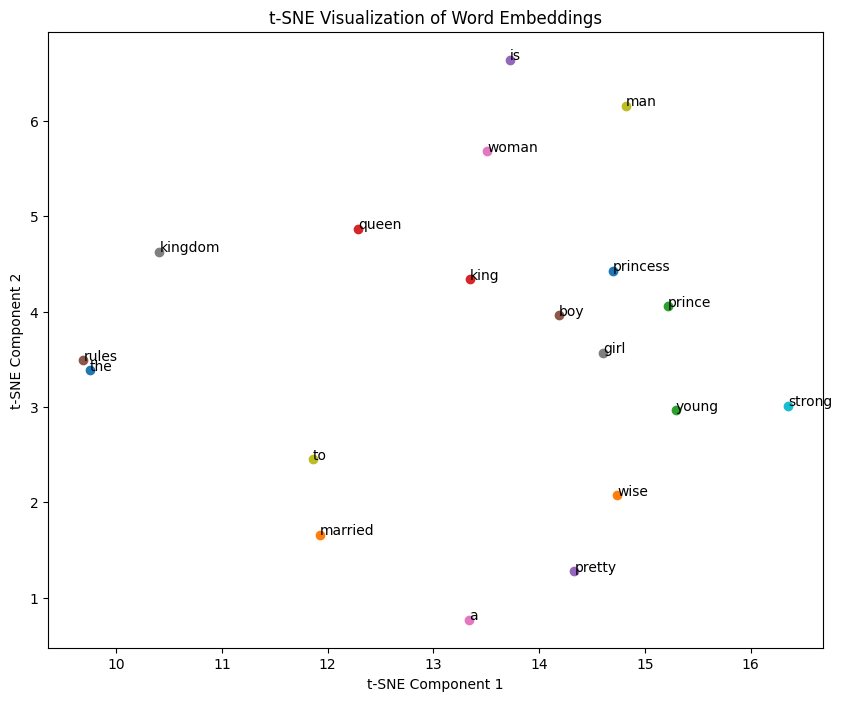

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


corpus = ["king is a strong man",
          "queen is a wise woman",
          "boy is a young man",
          "girl is a young woman",
          "prince is a young king",
          "princess is a young queen",
          "man is strong",
          "woman is pretty",
          "king is married to queen",
          "queen rules the kingdom"]Count the frequencies of all byte pairs in the train set.


words = []
for sentence in corpus:
    words.extend(sentence.split())


vocab = set(words)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)


window_size = 2
skip_grams = []
for sentence in corpus:
    sentence_tokens = sentence.split()
    for i, target_word in enumerate(sentence_tokens):
        for j in range(max(0, i - window_size), min(len(sentence_tokens), i + window_size + 1)):
            if i != j:
                context_word = sentence_tokens[j]
                skip_grams.append((target_word, context_word))

embedding_dim = 100
inputs = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
flatten_layer = tf.keras.layers.Flatten()(embedding_layer)
output = tf.keras.layers.Dense(vocab_size, activation='softmax')(flatten_layer)
model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')


target_words = [word_to_idx[w] for w, _ in skip_grams]
context_words = [word_to_idx[w] for _, w in skip_grams]
model.fit(np.array(target_words), np.array(context_words), epochs=50, batch_size=32)


embeddings = model.layers[1].get_weights()[0]

def find_similar_words(word, top_n=5):
    if word not in word_to_idx:
        print("Word not found in vocabulary!")
        return
    word_idx = word_to_idx[word]
    word_embedding = embeddings[word_idx]
    cosine_similarities = np.dot(embeddings, word_embedding) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_embedding))
    most_similar_indices = np.argsort(cosine_similarities)[::-1][:top_n]
    most_similar_words = [idx_to_word[idx] for idx in most_similar_indices]
    return most_similar_words

relation_words = ["king", "queen", "man", "woman"]
relation_vector = embeddings[word_to_idx["king"]] - embeddings[word_to_idx["queen"]] + embeddings[word_to_idx["woman"]]
relation_similar_words = [find_similar_words(word) for word in relation_words]
print("Relation: King - Queen + Man = Woman")
for i in range(len(relation_words)):
    print(relation_words[i], ":", relation_similar_words[i])

def plot_embeddings(embeddings, words):
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(words)//2, 30))
    embedding_tsne = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i in range(len(words)):
        plt.scatter(embedding_tsne[i, 0], embedding_tsne[i, 1])
        plt.annotate(words[i], (embedding_tsne[i, 0], embedding_tsne[i, 1]))
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization of Word Embeddings")
    plt.show()


plot_embeddings(embeddings, list(vocab))


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def read_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read().splitlines()
    return data

train_corpus = read_data('/storage/nandani/Group01_Nandani_Kajal_Assignment-2/train.txt')
val_corpus = read_data('/storage/nandani/Group01_Nandani_Kajal_Assignment-2/val.txt')
test_corpus = read_data('/storage/nandani/Group01_Nandani_Kajal_Assignment-2/test.txt')



corpus = train_corpus + val_corpus + test_corpus
words = []
for sentence in corpus:
    words.extend(sentence.split())


vocab = set(words)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)


def generate_skipgrams(corpus, window_size):
    skip_grams = []
    for sentence in corpus:
        sentence_tokens = sentence.split()
        for i, target_word in enumerate(sentence_tokens):
            for j in range(max(0, i - window_size), min(len(sentence_tokens), i + window_size + 1)):
                if i != j:
                    context_word = sentence_tokens[j]
                    skip_grams.append((target_word, context_word))
    return skip_grams


window_size = 2
skip_grams = generate_skipgrams(train_corpus, window_size)


embedding_dim = 100
inputs = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
flatten_layer = tf.keras.layers.Flatten()(embedding_layer)
output = tf.keras.layers.Dense(vocab_size, activation='softmax')(flatten_layer)
model = tf.keras.Model(inputs=inputs, outputs=output)


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')


target_words = [word_to_idx[w] for w, _ in skip_grams]
context_words = [word_to_idx[w] for _, w in skip_grams]
model.fit(np.array(target_words), np.array(context_words), epochs=5, batch_size=32)

embeddings = model.layers[1].get_weights()[0]


val_similar_words = {}
for word in vocab:
    similar_words = find_similar_words(word)
    val_similar_words[word] = similar_words


plot_embeddings(embeddings, list(vocab))


test_similar_words = {}
for word in vocab:
    similar_words = find_similar_words(word)
    test_similar_words[word] = similar_words

plot_embeddings(embeddings, list(vocab))
